# Aproksymacja liniowa

***Zadanie 1.***

Zdefiniuj funkcję liniową z dowolnymi paramterami $a,b$. Przeprowadź symulację zaszumionego próbkowania jej wartości z przedziału [0,50]. Wykreśl funkcję wraz z jej zaszumionymi próbkami, a następnie dokonaj aproskymacji swojej funkcji za pomocą:
* funkcji liniowej,
* funkcji kwadratowej,
* wielomianu trzeciego stopnia.

Zastosuj metodę/metody minimalizujące najmniejszych kwadratów (normę średniokwadratową np. funkcję *curve_fit* z [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)).

Porównaj otrzymane wyniki z metodami interpolacji poznanymi na poprzednich zajęciach. W tym celu przeprowadź interpolację wygenerowanych danych za pomocą wielomianu interpolacyjnego Lagrange'a oraz za pomocą funkcji sklejanych.

*Wskazówka*: Najpierw wygerneruj tablicę 100 wartości $(x_i, f(x_i))$ dla $x_i \in [0,50]$. Następnie za pomocą np. funkcji *np.random.normal* wygeneruj 100-elementową tablicę szumu losowego i dodaj ją do wygenerowanych **wartości** funkcji (tj. do $f(x_i)$).

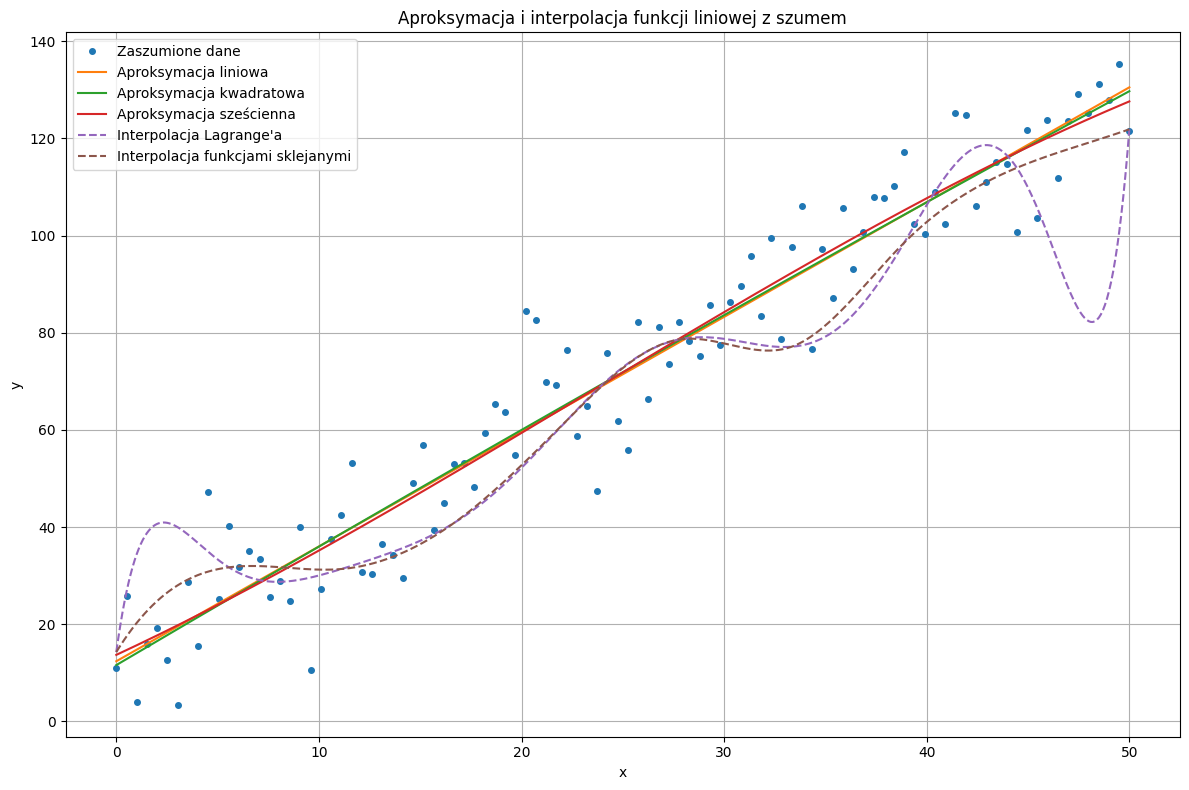

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import lagrange, interp1d

# 1. Funkcja liniowa z szumem
def linear_function(x, a, b):
    return a * x + b

# Parametry funkcji
a_true, b_true = 2.5, 10

# Generowanie danych
x_vals = np.linspace(0, 50, 100)
y_clean = linear_function(x_vals, a_true, b_true)

# Dodanie szumu
noise = np.random.normal(0, 10, size=x_vals.shape)
y_noisy = y_clean + noise

# Aproksymacja: funkcja liniowa
popt_linear, _ = curve_fit(linear_function, x_vals, y_noisy)

# Aproksymacja: funkcja kwadratowa
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

popt_quadratic, _ = curve_fit(quadratic, x_vals, y_noisy)

# Aproksymacja: funkcja sześcienna
def cubic(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

popt_cubic, _ = curve_fit(cubic, x_vals, y_noisy)

# Interpolacja Lagrange'a i funkcjami sklejanymi (na podstawie 10 punktów)
x_interp = np.linspace(0, 50, 10)
y_interp = linear_function(x_interp, a_true, b_true) + np.random.normal(0, 10, size=x_interp.shape)
poly_lagrange = lagrange(x_interp, y_interp)
spline = interp1d(x_interp, y_interp, kind='cubic')

# Wykres
x_plot = np.linspace(0, 50, 500)
plt.figure(figsize=(12, 8))
plt.plot(x_vals, y_noisy, 'o', label='Zaszumione dane', markersize=4)
plt.plot(x_plot, linear_function(x_plot, *popt_linear), label='Aproksymacja liniowa')
plt.plot(x_plot, quadratic(x_plot, *popt_quadratic), label='Aproksymacja kwadratowa')
plt.plot(x_plot, cubic(x_plot, *popt_cubic), label='Aproksymacja sześcienna')
plt.plot(x_plot, poly_lagrange(x_plot), '--', label='Interpolacja Lagrange\'a')
plt.plot(x_plot, spline(x_plot), '--', label='Interpolacja funkcjami sklejanymi')

plt.title('Aproksymacja i interpolacja funkcji liniowej z szumem')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


***Zadanie 2.***


Wykorzystaj metody aproksymacji do rozwiązania zadania z kierowcą z poprzednich ćwiczeń.


Kierowca jadący z miasta A do miasta B, zauważywszy na drodze fotoradar, zaczął gwałtownie hamować. Przebieg jego położenia, zarejestrowany przez nawigację, pokazano w poniższej tabeli. Wiedząc, że radar znajduje się w punkcie o współrzędnej 79.6 m, oszacuj kiedy kierowca minął fotoradar (w tym celu skorzystaj z jednej z metod z laboratorium 3) oraz z jaką prędkością wtedy jechał (wykorzystaj relację drogi i prędkości znaną z fizyki). 

|czas \[s\]|położenie \[m\]|
|--|--|
|0.0|0.0|
|1.0|42.7|
|2.0|73.2|
|3.0|92.5|

Czas przejazdu przez fotoradar (funkcja sklejanych): 2.2758 s
Prędkość w tym momencie (funkcja sklejanych): 21.68 m/s
Czas przejazdu przez fotoradar (wielomian Lagrange'a): 2.2758 s
Prędkość w tym momencie (wielomian Lagrange'a): 21.68 m/s


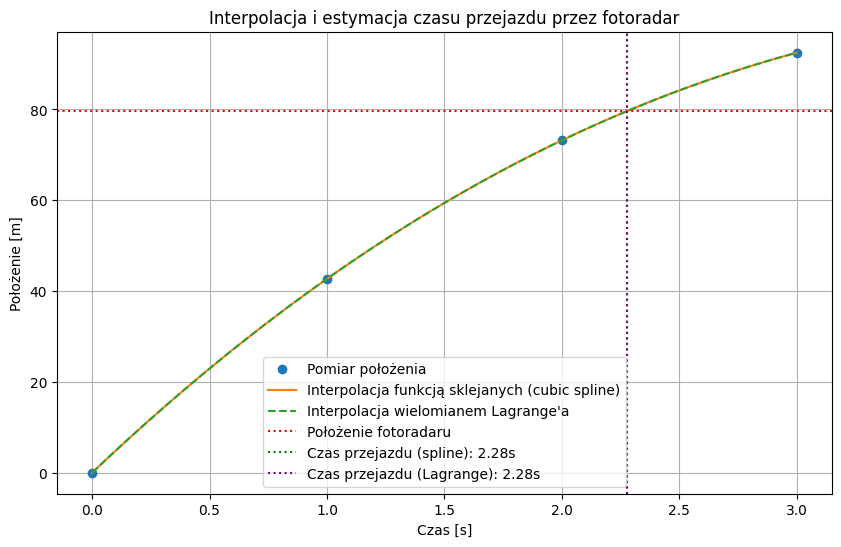

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, lagrange

# Dane z tabeli
times = np.array([0.0, 1.0, 2.0, 3.0])      # w sekundach
positions = np.array([0.0, 42.7, 73.2, 92.5])  # w metrach

radar_pos = 79.6  # pozycja fotoradaru w metrach

# 1. Interpolacja funkcją sklejanych (cubic spline)
spline = interp1d(times, positions, kind='cubic')

# 2. Wielomian interpolacyjny Lagrange'a
poly_lagr = lagrange(times, positions)

# Funkcja do znalezienia przybliżonego czasu przejazdu przez fotoradar
def estimate_time(func, target_pos, t_min, t_max, tol=1e-5):
    """ Znajduje przybliżony czas t, gdy func(t) = target_pos
        szukając rozwiązania równania func(t) - target_pos = 0 metodą bisekcji."""
    a, b = t_min, t_max
    fa = func(a) - target_pos
    fb = func(b) - target_pos

    if fa * fb > 0:
        raise ValueError("Funkcja nie zmienia znaku na podanym przedziale.")

    while b - a > tol:
        c = (a + b) / 2
        fc = func(c) - target_pos
        if fc == 0:
            return c
        elif fa * fc < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
    return (a + b) / 2

# Szukamy czasu dla fotoradaru w zakresie od 1.5 do 3 sekund (bo wiadomo, że radar jest między 73.2 a 92.5 m)
t_est_spline = estimate_time(spline, radar_pos, 1.5, 3.0)
t_est_lagr = estimate_time(poly_lagr, radar_pos, 1.5, 3.0)

# Obliczamy prędkość - pochodna funkcji położenia względem czasu.
# Przybliżenie prędkości metodą różnic skończonych z aproksymowanej funkcji
def velocity(func, t, h=1e-4):
    return (func(t + h) - func(t - h)) / (2 * h)

v_est_spline = velocity(spline, t_est_spline)
v_est_lagr = velocity(poly_lagr, t_est_lagr)

# Wyniki
print(f"Czas przejazdu przez fotoradar (funkcja sklejanych): {t_est_spline:.4f} s")
print(f"Prędkość w tym momencie (funkcja sklejanych): {v_est_spline:.2f} m/s")

print(f"Czas przejazdu przez fotoradar (wielomian Lagrange'a): {t_est_lagr:.4f} s")
print(f"Prędkość w tym momencie (wielomian Lagrange'a): {v_est_lagr:.2f} m/s")

# Wykresy
t_fine = np.linspace(0, 3, 100)
plt.figure(figsize=(10,6))
plt.plot(times, positions, 'o', label='Pomiar położenia')
plt.plot(t_fine, spline(t_fine), label='Interpolacja funkcją sklejanych (cubic spline)')
plt.plot(t_fine, poly_lagr(t_fine), '--', label='Interpolacja wielomianem Lagrange\'a')

plt.axhline(radar_pos, color='red', linestyle=':', label='Położenie fotoradaru')
plt.axvline(t_est_spline, color='green', linestyle=':', label=f'Czas przejazdu (spline): {t_est_spline:.2f}s')
plt.axvline(t_est_lagr, color='purple', linestyle=':', label=f'Czas przejazdu (Lagrange): {t_est_lagr:.2f}s')

plt.title('Interpolacja i estymacja czasu przejazdu przez fotoradar')
plt.xlabel('Czas [s]')
plt.ylabel('Położenie [m]')
plt.legend()
plt.grid(True)
plt.show()


***Zadanie 3.***


Spróbuj przeprowadzić regresję liniową (aproksymację funkcją liniową) na rzeczywistych danych (np. z repozytorium [UCI](https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table)). Wykorzystaj stworzony model do predykcji. Dla ułatwienia możesz zastosować funkcję z biblioteki [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Załaduj dane Boston Housing (klasyczny zbiór regresyjny)
data = load_boston()
X = data.data      # cechy (np. średnia liczba pokoi, wiek budynku itd.)
y = data.target    # wartość ceny domu

# Wybierz jedną cechę dla prostoty (np. średnia liczba pokoi - feature nr 5)
X_simple = X[:, 5].reshape(-1, 1)

# Podziel dane na zbiór treningowy i testowy (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

# Stwórz model regresji liniowej
model = LinearRegression()

# Wytrenuj model
model.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred = model.predict(X_test)

# Wyświetl współczynniki regresji
print("Współczynnik kierunkowy (a):", model.coef_[0])
print("Wyraz wolny (b):", model.intercept_)

# Ocena modelu
print("Średni błąd kwadratowy (MSE):", mean_squared_error(y_test, y_pred))
print("Współczynnik determinacji (R^2):", r2_score(y_test, y_pred))

# Wykres: rzeczywiste vs przewidywane ceny
plt.scatter(X_test, y_test, color='blue', label='Rzeczywiste ceny')
plt.scatter(X_test, y_pred, color='red', label='Predykcje modelu')
plt.xlabel('Średnia liczba pokoi')
plt.ylabel('Cena domu (w tysiącach $)')
plt.title('Regresja liniowa na danych Boston Housing')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'sklearn'